In [1]:
%load_ext autoreload
%autoreload 2

In [107]:
# Imports
import os
import pandas as pd
from dw_events.temperature_compensation.kalman_filter import KalmanFilter1D, KalmanFilter
from dw_events.data.make_dataset import DataGetter
from dw_events.data.utils import make_dt_list, get_dataframe_str_subset
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [85]:
start = datetime.datetime(2022, 9, 1)
end = datetime.datetime(2022, 9, 2)
data_path = \
    "_".join(
        [
            "../data/raw/strain_data",
            str(start.year),
            str(start.month),
            str(start.day),
            str(end.year),
            str(end.month),
            str(end.day),
            ".parquet"
        ]
    )
datagetter = DataGetter(start, end)
try:
    strain_data = pd.read_parquet(data_path)
    datagetter.merged_signals = strain_data
except:
    strain_data = datagetter.get_strain_data()
    #strain_data.to_parquet(data_path)

In [86]:
# Get strain line data BCN
BCN_signals = datagetter.get_dataframe_str_subset('BCN')
# Temperature data
temperature_data = datagetter.get_dataframe_str_subset('TFBG')
bottom_temperature_data = temperature_data.filter(regex="_B")

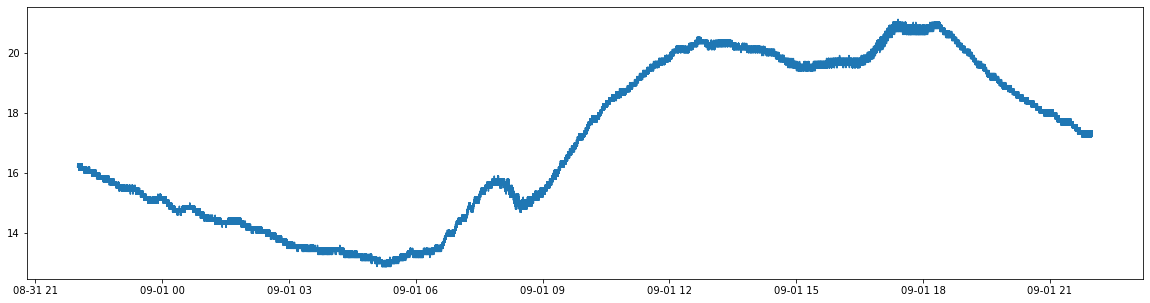

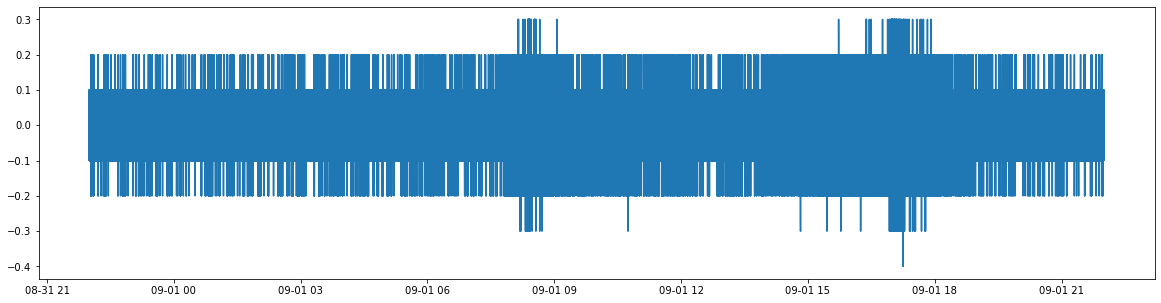

In [95]:
plt.figure(figsize=(20,5))
plt.plot(bottom_temperature_data)
plt.show()
plt.figure(figsize=(20,5))

plt.plot(bottom_temperature_data - bottom_temperature_data.shift(1))

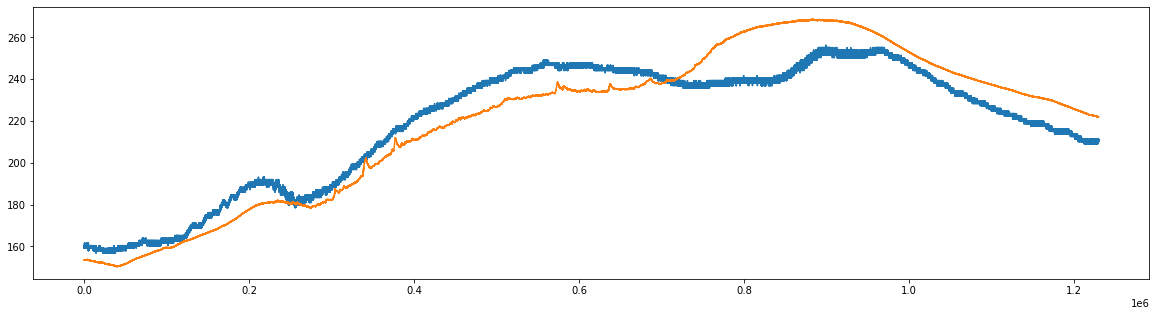

In [105]:
plt.figure(figsize=(20,5))
alpha = 12.15
plt.plot(alpha*bottom_temperature_data.iloc[start:stop].values)
plt.plot(series[start_series:])

In [252]:
alpha = 12.15

Fs = 20
beta = 0.1
a_matrix = \
    np.array(
        [
            np.array([1, 0]),
            np.array([0, 1]),
        ]
        )
b_matrix = \
    np.array(
        [
            np.array([0, beta]),
            np.array([0, beta]),
        ])
c_matrix = \
    np.array([np.array([alpha, 0])])

In [256]:
start = 0
stop = 1000000
sensor = 3
Tb = bottom_temperature_data
delta_Tb = Tb - Tb.shift(1)

measurements = BCN_signals.iloc[start:stop, sensor]
inputs = pd.DataFrame(
    {
        'Tb': Tb.iloc[start:stop].values[:,0],
        'delta_Tb': delta_Tb.iloc[start:stop].values[:,0]
    }, index = measurements.index)

q_process_variance =  \
    np.array([
        np.array([1e-6, 0]),
        np.array([1e-10, 1e-2])
    ])
r_estimated_measurement_variance = 1e5 * np.eye(c_matrix.shape[0])

x_hat_0 = np.array([measurements[0]/alpha, 0])
P_0 = np.array([np.array([1, 0]), np.array([0, 1])])

kf = \
    KalmanFilter(
        q_process_variance,
        r_estimated_measurement_variance,
        x_hat_0,
        P_0,
        a_matrix = a_matrix,
        b_matrix = b_matrix,
        c_matrix = c_matrix
    )
compensated_data = kf.apply_filter(measurements, inputs)
filtered_data = pd.Series([x[0] for x in kf.filtered_data])

c:\users\max\documents\owi_lab\code\packages\dw_events\dw_events\dw_events\temperature_compensation\kalman_filter.py:144: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  filtered_data = pd.Series()


KeyboardInterrupt: 

In [ ]:
start_series = 0
filtered_data = pd.Series([x[0] for x in kf.filtered_data], index = measurements.index)*alpha
compensated_data = BCN_signals.iloc[start+start_series:stop,sensor] - filtered_data

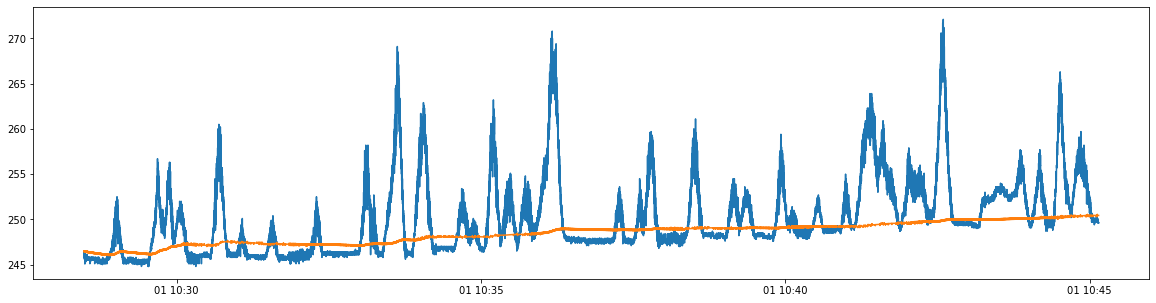

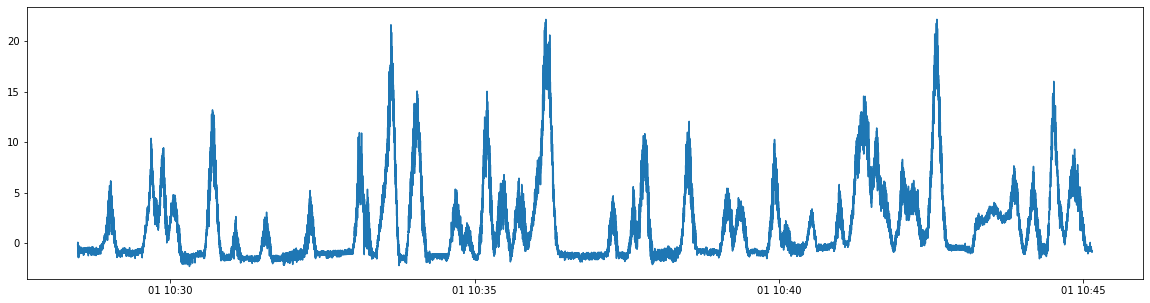

In [ ]:
# Plot the combined portfolio
plt.figure(figsize=(20,5))
plt.plot(BCN_signals.iloc[start+start_series:stop,sensor])
plt.plot(filtered_data.iloc[start_series:])

plt.show()
# Plot the combined portfolio
plt.figure(figsize=(20,5))
plt.plot(compensated_data)
plt.show()

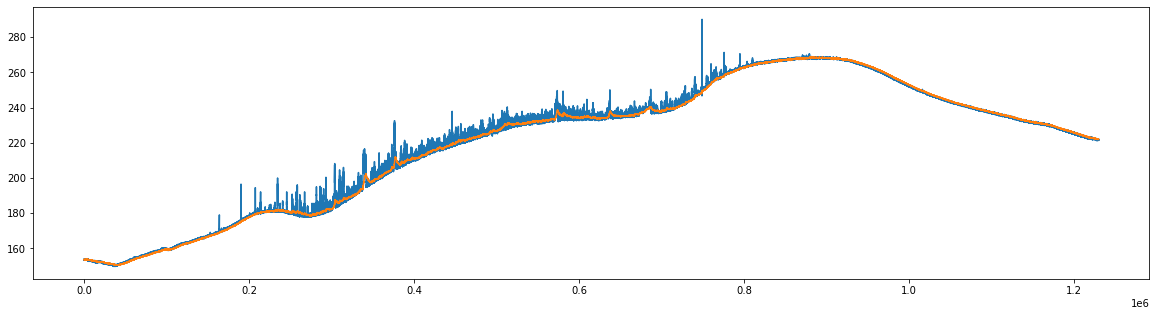

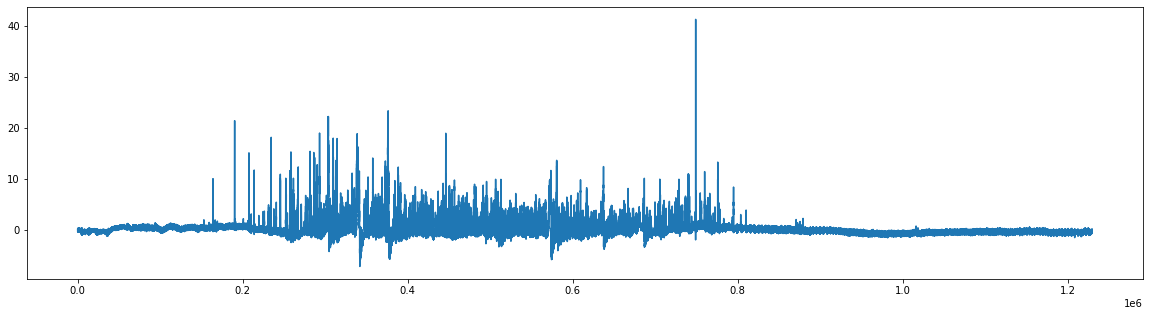

1.4960159864439004


In [98]:
start = 500000
stop = 2000000
process_variance = 1e-4                 # Q
estimated_measurement_variance = 1000   # R
P0 = 0
sensor = 1
x0 = BCN_signals.iloc[start,sensor]

kf = \
    KalmanFilter1D(
        process_variance,
        estimated_measurement_variance,
        x0,
        P0
    )
series = []
measurements = BCN_signals.iloc[start:stop,sensor].values
inputs = (bottom_temperature_data - bottom_temperature_data.shift(1)).iloc[start-1:stop-1].values


for i in range(len(measurements)):
    kf.input_latest_noisy_measurement(
        measurements[i],
        inputs[i],
        1,
        1
    )
    series.append(kf.get_latest_estimated_measurement()[0])

# Plot the combined portfolio
plt.figure(figsize=(20,5))
start_series = 0
plt.plot(BCN_signals.iloc[start+start_series:stop,sensor].values)
plt.plot(series[start_series:])

plt.show()
# Plot the combined portfolio
plt.figure(figsize=(20,5))
plt.plot(BCN_signals.iloc[start+start_series:stop,sensor].values - series[start_series:])
plt.show()

print((BCN_signals.iloc[start+start_series:stop,sensor].values - series[start_series:]).std())

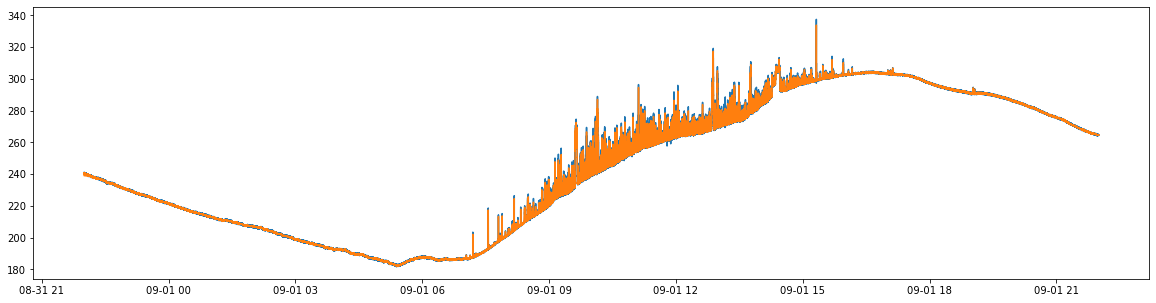

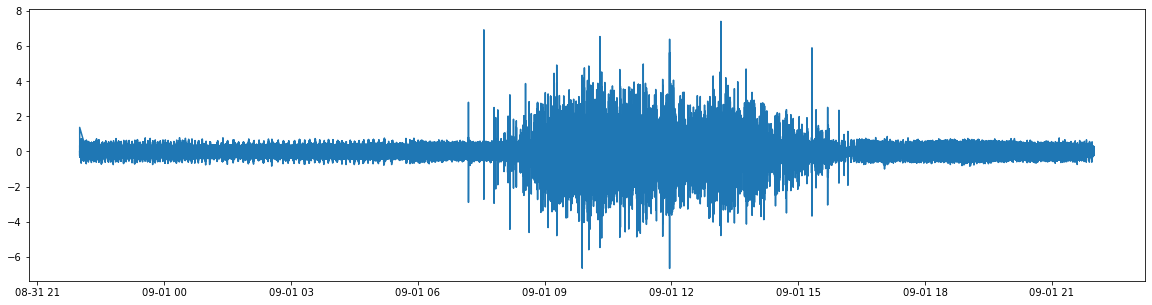

In [75]:
start = 0
stop = 5000000

Q = 1e-4
R = 1e-3
x0 = BCN_signals.iloc[start,3]
P0 = 0

kf = \
    KalmanFilter1D(
        Q,
        R,
        posteri_estimate=x0,
        posteri_error_estimate=P0)
strain_data = BCN_signals.iloc[start:stop,3]
filtered_data = kf.filter_data(strain_data)
compensated_data = strain_data - filtered_data

# Plot the combined portfolio
plt.figure(figsize=(20,5))
start_series = 30000
plt.plot(strain_data)
plt.plot(filtered_data)
plt.show()
plt.figure(figsize=(20,5))
plt.plot(compensated_data)
plt.show()

In [76]:
# Get strain line data TCN
TCN_signals = datagetter.get_dataframe_str_subset('TCN')
# Temperature data
temperature_data = datagetter.get_dataframe_str_subset('TFBG')
tcn_temperature_data = temperature_data.filter(regex="TCN")

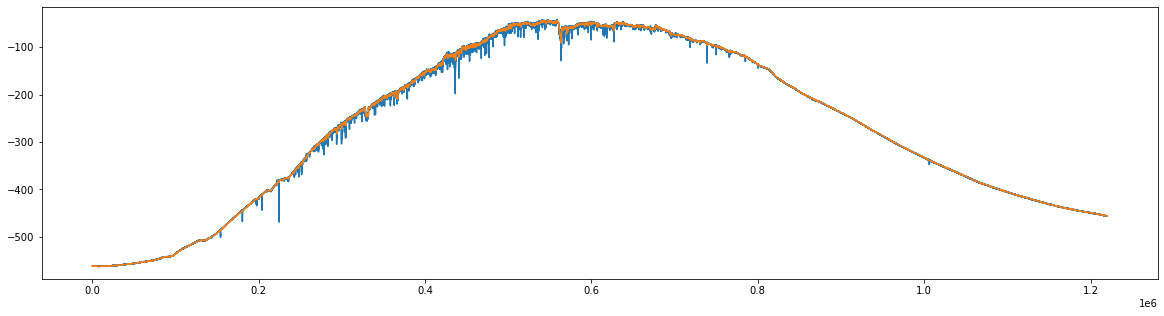

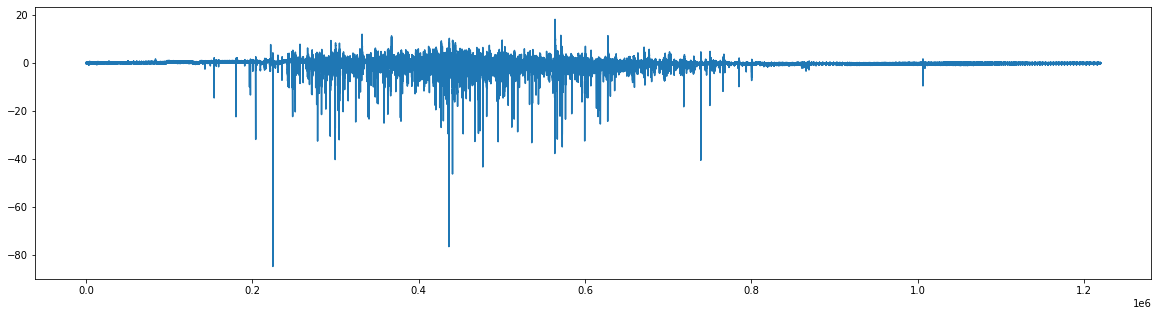

In [77]:
start = 500000
stop = 2000000
process_variance = 1e-3                # Q
estimated_measurement_variance = 100   # R
P0 = 0
sensor = 3
x0 = TCN_signals.iloc[start,sensor]

kf = \
    KalmanFilter1D(
        process_variance,
        estimated_measurement_variance,
        x0,
        P0
    )
series = []
measurements = TCN_signals.iloc[start:stop,sensor].values
inputs = (tcn_temperature_data - tcn_temperature_data.shift(1)).iloc[start-1:stop-1].values


for i in range(len(measurements)):
    kf.input_latest_noisy_measurement(
        measurements[i],
        inputs[i],
        1,
        1
    )
    series.append(kf.get_latest_estimated_measurement()[0])

# Plot the combined portfolio
plt.figure(figsize=(20,5))
start_series = 10000
plt.plot(measurements[start_series:])
plt.plot(series[start_series:])

plt.show()
# Plot the combined portfolio
plt.figure(figsize=(20,5))
plt.plot(measurements[start_series:] - series[start_series:])
plt.show()

## Low Intensity Day 

In [78]:
start = datetime.datetime(2022, 12, 1)
end = datetime.datetime(2022, 12, 2)
data_path = \
    "_".join(
        [
            "../data/raw/strain_data",
            str(start.year),
            str(start.month),
            str(start.day),
            str(end.year),
            str(end.month),
            str(end.day),
            ".parquet"
        ]
    )
datagetter = DataGetter(start, end)
try:
    strain_data = pd.read_parquet(data_path)
    datagetter.merged_signals = strain_data
except:
    strain_data = datagetter.get_strain_data()
    #strain_data.to_parquet(data_path)

In [79]:
# Get strain line data BCN
BCN_signals = datagetter.get_dataframe_str_subset('BCN')
# Temperature data
temperature_data = datagetter.get_dataframe_str_subset('TFBG')
bottom_temperature_data = temperature_data.filter(regex="_B")

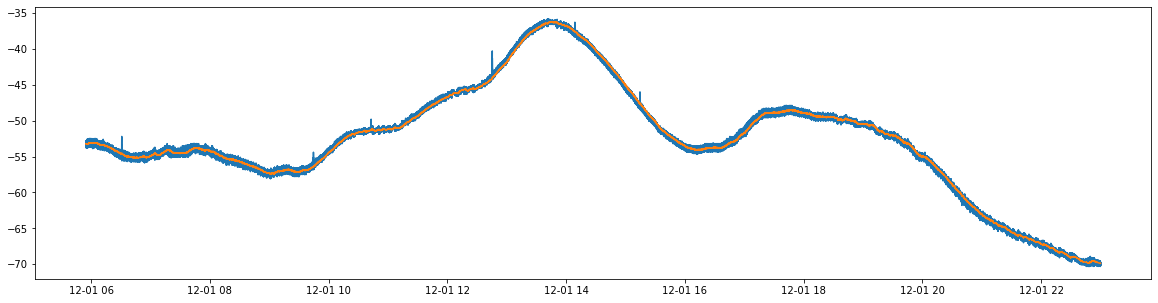

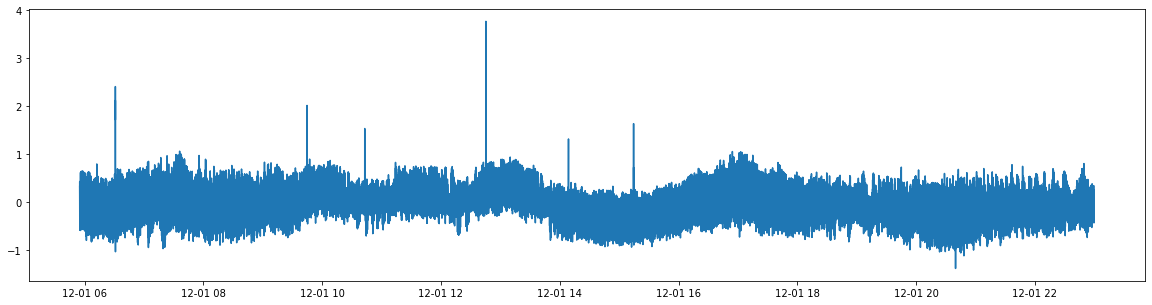

In [80]:
start = 500000
stop = 2000000
process_variance = 1e-4                 # Q
estimated_measurement_variance = 500  # R
P0 = 0
sensor = 1
x0 = BCN_signals.iloc[start,sensor]

kf = \
    KalmanFilter1D(
        process_variance,
        estimated_measurement_variance,
        x0,
        P0
    )
series = []
measurements = BCN_signals.iloc[start:stop,sensor]
inputs = (bottom_temperature_data - bottom_temperature_data.shift(1)).iloc[start-1:stop-1]


for i in range(len(measurements)):
    kf.input_latest_noisy_measurement(
        measurements.values[i],
        inputs.values[i],
        1,
        0.1
    )
    series.append(kf.get_latest_estimated_measurement()[0])

filtered_data = pd.Series(series, index=measurements.index)

# Plot the combined portfolio
plt.figure(figsize=(20,5))
start_series = 10000
plt.plot(measurements.iloc[start_series:])
plt.plot(filtered_data.iloc[start_series:])

plt.show()
# Plot the combined portfolio
plt.figure(figsize=(20,5))
plt.plot(measurements.iloc[start_series:] - filtered_data.iloc[start_series:])
plt.show()

In [81]:
# Get strain line data TCN
TCN_signals = datagetter.get_dataframe_str_subset('TCN')
# Temperature data
temperature_data = datagetter.get_dataframe_str_subset('TFBG')
tcn_temperature_data = temperature_data.filter(regex="TCN")

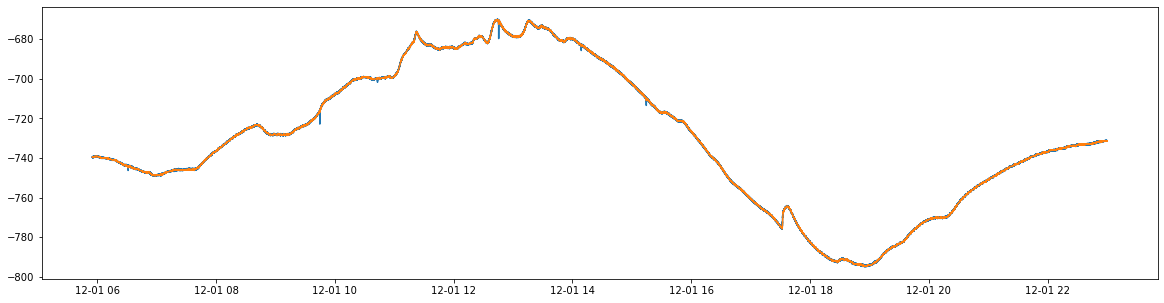

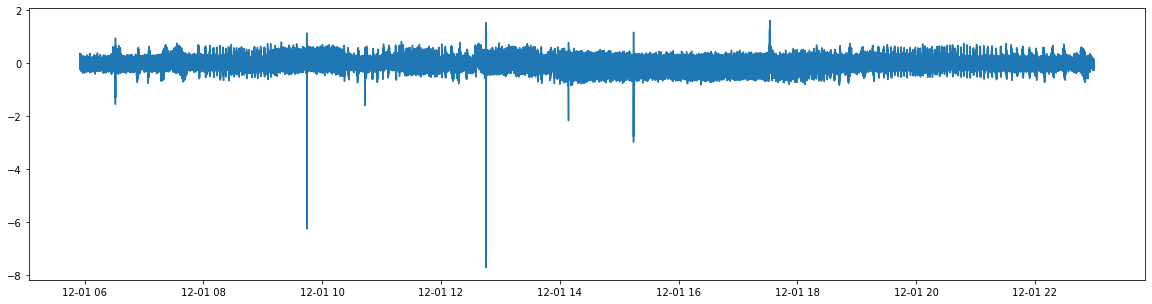

In [82]:
start = 500000
stop = 2000000
process_variance = 1e-3                 # Q
estimated_measurement_variance = 10   # R
P0 = 0
sensor = 3
x0 = TCN_signals.iloc[start,sensor]

kf = \
    KalmanFilter1D(
        process_variance,
        estimated_measurement_variance,
        x0,
        P0
    )
series = []
measurements = TCN_signals.iloc[start:stop,sensor]
inputs = (tcn_temperature_data - tcn_temperature_data.shift(1)).iloc[start-1:stop-1]


for i in range(len(measurements)):
    kf.input_latest_noisy_measurement(
        measurements.values[i],
        inputs.values[i],
        1,
        1
    )
    series.append(kf.get_latest_estimated_measurement()[0])

filtered_data = pd.Series(series, index=measurements.index)

# Plot the combined portfolio
plt.figure(figsize=(20,5))
start_series = 10000
plt.plot(measurements.iloc[start_series:])
plt.plot(filtered_data.iloc[start_series:])

plt.show()
# Plot the combined portfolio
plt.figure(figsize=(20,5))
plt.plot(measurements.iloc[start_series:] - filtered_data.iloc[start_series:])
plt.show()